## 这是用来测试 PSO 后的参数是否能够成功模拟出路径

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from shapely import Point, LineString, Polygon
import shapely
import random
from enum import Enum
from rasterio.mask import mask
from CPP_Planner import CPP_Planner_Kit
import matplotlib

# matplotlib.use('macosx')


In [3]:
# hard-code 各个列表
swath_sep_indxes = [0, 28, 39, 49, 71]
# swath_sep_indxes = [17, 25, 39, 49, 71]
useful_land_indexes = [0, 4, 5, 6]
# 一些农机数据
vehicle_weight = 1980 + 342.5  # 拖拉机 + 耕作机械 重量（kg）
vehicle_wheel_width = 1440  # 农机轮距（mm）

# opti_path = '../PSO_opt_result/opt19/pso_result.csv'
opti_path = '../PSO_APF_analysis/opt16/pso_result.csv'
# opti_path = r'../PSO_APF_SMALL_LAND/opt5/pso_result.csv'
# real_swath_path = '../Scratch/test_Load_Shp/test_shps/swath_group_1.shp'
# straight_swath_path = 'GIS_data/straight_swaths/straight_swaths.shp'
real_swath_path = r'GIS_data/路径规划优化用数据/all_swaths/all_swaths_group.shp'
straight_swath_path = r'GIS_data/路径规划优化用数据/all_swaths/all_straight_swaths_group.shp'
opti_parameters = pd.read_csv(opti_path)
real_swath = gpd.read_file(real_swath_path)
straight_swath = gpd.read_file(straight_swath_path)

all_land = gpd.read_file('../Scratch/test_Load_Shp/shp_file/村地和道路/村地地块区域.shp')
print(opti_parameters.shape)
print('straight and real swaths: ', len(straight_swath), end=' ')
print(len(real_swath))

(10, 6)
straight and real swaths:  71 71


In [4]:
# 提取地形图
# with rasterio.open('GIS_data/路径规划优化用数据/2m_pClouds_regen_dem_cm.tif') as dem_src:
#     dem_array = dem_src.read(1)
# with rasterio.open('GIS_data/路径规划优化用数据/Aspect_clip_pcGen_2m_cm1.tif') as aspect_src:
with rasterio.open('GIS_data/路径规划优化用数据/Aspect_clip_pcGen_2m_21.tif') as aspect_src:
    aspect_array = aspect_src.read(1)
# with rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif') as slope_src:
#     slope_array = slope_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/Curvatu_clip_pcGen_2m_cm1.tif') as curvature_src:
    curvature_array = curvature_src.read(1)
    
with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/dem_halfM_clip1.tif') as dem_src:
    dem_array = dem_src.read(1)
# with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Aspect_halfM_clip1.tif') as aspect_src:
#     aspect_array = aspect_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Slope_clip_halfM1.tif') as slope_src:
    slope_array = slope_src.read(1)
# with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Curvatu_halfM_clip1.tif') as curvature_src:
#     curvature_array = curvature_src.read(1)
[dem_array.shape, aspect_array.shape, slope_array.shape, curvature_array.shape]

[(2025, 1767), (507, 442), (2025, 1767), (507, 440)]

## 在这里确定验证的地块: land_ind (4 in all)

In [5]:
land_ind = 0
single_land = CPP_Planner_Kit.get_single_shp(all_land, useful_land_indexes[land_ind])
# 选取特定的 swaths 进行演示
real_swath = real_swath[swath_sep_indxes[land_ind]: swath_sep_indxes[land_ind + 1]]
straight_swath = straight_swath[swath_sep_indxes[land_ind]: swath_sep_indxes[land_ind + 1]]
print('Now swaths contains: {} swaths'.format(len(real_swath)))# 决定是否使用 道格拉斯普克 简化真实曲线

straight_swaths = []
for temp_line in real_swath.geometry:
    temp_simplified_line = temp_line.simplify(0.5, preserve_topology=False)
    straight_swaths.append(temp_simplified_line)
# straight_swath = gpd.GeoDataFrame(geometry=straight_swaths, crs=real_swath.crs)

# 计算地块内平均值和最小值
# slope_src = rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif')
slope_src = rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Slope_clip_halfM1.tif')
clip_slope_raster, _trans = mask(slope_src, single_land.geometry.values.tolist(), crop=True)
single_slope_mean = np.mean(clip_slope_raster[clip_slope_raster != clip_slope_raster.min()])
single_slope_min = np.min(clip_slope_raster[clip_slope_raster != clip_slope_raster.min()])
single_slope_median = np.median(clip_slope_raster[clip_slope_raster != clip_slope_raster.min()])
[single_slope_mean, single_slope_min, single_slope_median]

Now swaths contains: 28 swaths


[8.674452, 0.0, 7.387925]

In [6]:
opti_parameters

,Unnamed: 0,0,1,2,3,4
0,0,0.004118,-0.001300,-0.080964,-0.099277,0.326718
1,1,0.001619,-0.001281,-0.089542,0.059003,0.341224
2,2,0.000477,-0.000741,-0.093438,0.041047,0.331251
3,3,0.002772,-0.000860,-0.087168,0.102018,0.334393
4,4,0.003922,-0.001306,-0.080367,-0.525654,0.335446
5,5,0.003852,-0.000865,-0.091921,-0.759408,0.332282
6,6,-0.006198,-0.001844,-0.092706,-0.008461,0.340999
7,7,0.000102,-0.000294,-0.088965,0.073228,0.330369
8,8,0.010605,-0.001337,-0.094931,-0.725322,0.338561
9,9,0.000455,-0.001018,-0.091577,-0.843462,0.326928


-0.0949307408293385


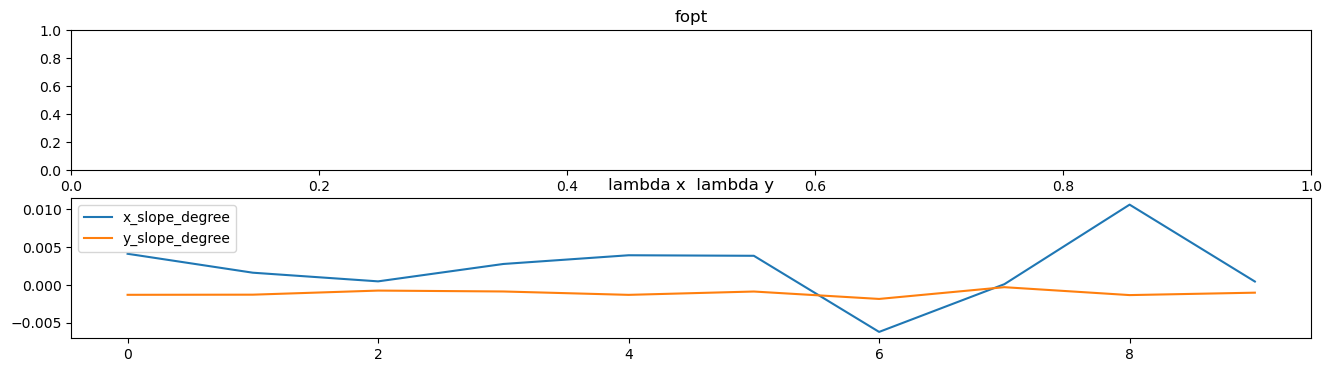

In [7]:
# %matplotlib qt5
# 显示优化的 fopt
# print(opti_parameters['4'].min())
print(opti_parameters['2'].min())
plt.figure(figsize=(16, 4))
plt.subplot(211)
plt.title('fopt')
# opti_parameters['4'].plot()
plt.subplot(212)
# plt.figure(figsize=(16, 4))
plt.title('lambda x  lambda y')
opti_parameters['0'].plot()
opti_parameters['1'].plot()
# opti_parameters['2'].plot()
# opti_parameters['3'].plot()
plt.legend(['x_slope_degree', 'y_slope_degree', 'x_cur', 'y_cur'])

In [8]:
# 找到最优 foptimal 的索引，取出其 xoff yoff 的参数
optimal_params = opti_parameters.iloc[opti_parameters['4'].idxmin()]
# optimal_params = opti_parameters.iloc[opti_parameters['2'].idxmin()]
# optimal_params = opti_parameters.iloc[opti_parameters['4'].idxmax()]
# optimal_params = opti_parameters.iloc[10]
optimal_params[1:]

0    0.004118
1   -0.001300
2   -0.080964
3   -0.099277
4    0.326718
Name: 0, dtype: float64

In [9]:
best_lambda_x, best_lambda_y = optimal_params[1], optimal_params[2]
# best_lambda_cur_x, best_lambda_cur_y = optimal_params[3], optimal_params[4]
# print(best_lambda_x, best_lambda_y, best_lambda_cur_x, best_lambda_cur_y)
print(best_lambda_x, best_lambda_y)

0.0041181923034102 -0.0012997265221032


/var/folders/r2/bv03lgdn7y58thlc1ntrzgvc0000gn/T/ipykernel_54994/4048228241.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_lambda_x, best_lambda_y = optimal_params[1], optimal_params[2]


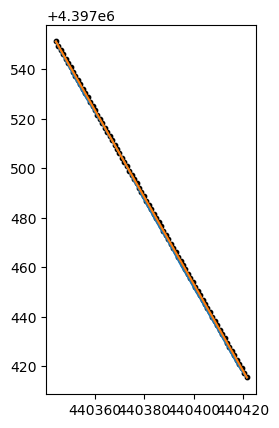

In [10]:
# 随机选择一个点进行采样和模拟
sample_ind = random.randint(0, len(real_swath))
sample_real_land = real_swath.geometry.iloc[sample_ind]
sample_straight_land = straight_swath.geometry.iloc[sample_ind]
# 采样
sample_points = np.arange(0, sample_real_land.length, 2)
sample_points = [sample_straight_land.interpolate(sample_point) for sample_point in sample_points]
# show
_, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(*sample_real_land.xy)
ax.plot(*sample_straight_land.xy)
for sample_point in sample_points:
    ax.scatter(*sample_point.xy, color='black', s=10)

In [11]:
# 取出当前位置上的地形信息
class raster(Enum):
    DEM = 1
    ASPECT = 2
    SLOPE = 3
    CURVATURE = 4
def get_11_from_raster(point: Point, category):    
    if category == raster.SLOPE:
        temp_raster = slope_array
        temp_src = slope_src
    elif category == raster.ASPECT:
        temp_raster = aspect_array
        temp_src = aspect_src
    elif category == raster.CURVATURE:
        temp_raster = curvature_array
        temp_src = curvature_src
    else:
        temp_raster = dem_array
        temp_src = dem_src
    row, col = temp_src.index(point.x, point.y)
    return temp_raster[row, col]

In [12]:
sample_points_data = []
for sample_point in sample_points:
    new_row = [
        sample_point.x, sample_point.y,
        get_11_from_raster(sample_point, category=raster.DEM),
        get_11_from_raster(sample_point, category=raster.ASPECT),
        get_11_from_raster(sample_point, category=raster.SLOPE),
        # abs(get_11_from_raster(sample_point, category=raster.SLOPE) - single_slope_mean),
        get_11_from_raster(sample_point, category=raster.CURVATURE)
    ]
    sample_points_data.append(new_row)

In [13]:
sample_points_data = np.array(sample_points_data)
# sample_points_data

In [14]:
def model_fit(lambdas, data):
    # print(data, '1')
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    curvature = data[5]
    # x_off = lambdas[0] * np.cos(aspect) * slope
    # y_off = lambdas[1] * np.sin(aspect) * slope
    x_off = lambdas[0] * np.cos(aspect) * slope + lambdas[2] * curvature
    y_off = lambdas[1] * np.sin(aspect) * slope + lambdas[3] * curvature
    
    new_x = origin_x + x_off
    new_y = origin_y + y_off
    return Point(new_x, new_y)

def model_fit_2(lambdas, data):
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    # slope = np.deg2rad(slope)
    curvature = data[5]
    # x_off = lambdas[0] * np.cos(aspect) * slope * vehicle_weight + lambdas[2] * (curvature / vehicle_wheel_width)
    # y_off = lambdas[1] * np.sin(aspect) * slope * vehicle_weight + lambdas[3] * (curvature / vehicle_wheel_width)
    x_off = lambdas[0] * np.cos(aspect) * slope * vehicle_weight + lambdas[2] * (np.abs(curvature) / vehicle_wheel_width)
    y_off = lambdas[1] * np.sin(aspect) * slope * vehicle_weight + lambdas[3] * (np.abs(curvature) / vehicle_wheel_width)

    new_x = origin_x + x_off
    new_y = origin_y + y_off
    return Point(new_x, new_y)

def model_fit_3(lambdas, data):
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    # slope = np.deg2rad(slope)
    aspect = np.deg2rad(aspect)
    # slope_rad = np.deg2rad(slope)
    x_off = lambdas[0] * np.cos(aspect) * vehicle_weight * slope
    y_off = lambdas[1] * np.sin(aspect) * vehicle_weight * slope

    new_x = origin_x + x_off
    new_y = origin_y + y_off
    return Point(new_x, new_y)

# no triangle
def model_fit_4(lambdas, data):
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    # slope = np.deg2rad(slope)
    curvature = data[5]
    # x_off = lambdas[0] * aspect * slope * vehicle_weight + lambdas[2] * (curvature / vehicle_wheel_width)
    # y_off = lambdas[1] * aspect * slope * vehicle_weight + lambdas[3] * (curvature / vehicle_wheel_width)
    x_off = lambdas[0] * aspect * slope * vehicle_weight + lambdas[2] * (np.abs(curvature) / vehicle_wheel_width)
    y_off = lambdas[1] * aspect * slope * vehicle_weight + lambdas[3] * (np.abs(curvature) / vehicle_wheel_width)

    new_x = origin_x + x_off
    new_y = origin_y + y_off
    return Point(new_x, new_y)

def model_fit_5(lambdas, data):
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    # slope = np.deg2rad(slope)
    curvature = data[5]
    print(data)
    print(np.cos(aspect) * (lambdas[0] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight)
    print(np.sin(aspect) * (lambdas[2] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight)
    # new_x = origin_x + np.cos(aspect) * (lambdas[0] * slope + lambdas[1] * curvature) * vehicle_wheel_width / vehicle_weight
    # new_y = origin_y + np.sin(aspect) * (lambdas[2] * slope + lambdas[1] * curvature) * vehicle_wheel_width / vehicle_weight
    new_x = origin_x + np.cos(aspect) * (lambdas[0] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight
    new_y = origin_y + np.sin(aspect) * (lambdas[2] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight
    # new_x = origin_x + np.abs(np.cos(aspect) * (lambdas[0] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight)
    # new_y = origin_y + np.abs(np.sin(aspect) * (lambdas[2] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight)
    return Point(new_x, new_y)

In [15]:
simul_points = []
for point in sample_points_data:
    # print(list(point))
    simul_points.append(model_fit_5(optimal_params[1:], point))
# print(simul_points[:3])
optimal_params[:]

[4.40344310e+05 4.39755118e+06 2.06060000e+04 1.80411682e+01
 9.65213871e+00 8.74938965e+00]
0.016729635195581606
-0.15224334522432495
[4.40345298e+05 4.39754944e+06 2.06220000e+04 3.98521156e+01
 6.14724827e+00 1.75006866e+01]
0.0012230325087342294
-0.20678343145819544
[ 4.40346286e+05  4.39754770e+06  2.06000000e+04  3.43593788e+01
  6.89551449e+00 -6.74934387e+00]
0.010044662204668325
-0.19843106939775768
[4.40347275e+05 4.39754596e+06 2.06430000e+04 5.33176498e+01
 9.14682770e+00 9.49897766e+00]
0.009379066644204244
-0.3743713015509764
[4.40348263e+05 4.39754422e+06 2.06170000e+04 1.21363304e+02
 4.16873980e+00 1.90002441e+01]
0.002429094092808054
-0.191765312202569
[4.40349251e+05 4.39754249e+06 2.06010000e+04 1.21363304e+02
 1.17942486e+01 1.90002441e+01]
-0.007704697277657793
-0.5186291343742255
[ 4.40350240e+05  4.39754075e+06  2.05620000e+04  9.02377396e+01
  1.12685299e+01 -2.85003662e+01]
-2.408867331813086e-05
-0.5886362435422575
[4.40351228e+05 4.39753901e+06 2.05690000e+0

/var/folders/r2/bv03lgdn7y58thlc1ntrzgvc0000gn/T/ipykernel_54994/2170814722.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(np.cos(aspect) * (lambdas[0] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight)
/var/folders/r2/bv03lgdn7y58thlc1ntrzgvc0000gn/T/ipykernel_54994/2170814722.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(np.sin(aspect) * (lambdas[2] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight)
/var/folders/r2/bv03lgdn7y58thlc1ntrzgvc0000gn/T/ipykernel_54994/2170814722.py:67: FutureWarning: Series.__getitem__ treating keys a

Unnamed: 0    0.000000
0             0.004118
1            -0.001300
2            -0.080964
3            -0.099277
4             0.326718
Name: 0, dtype: float64

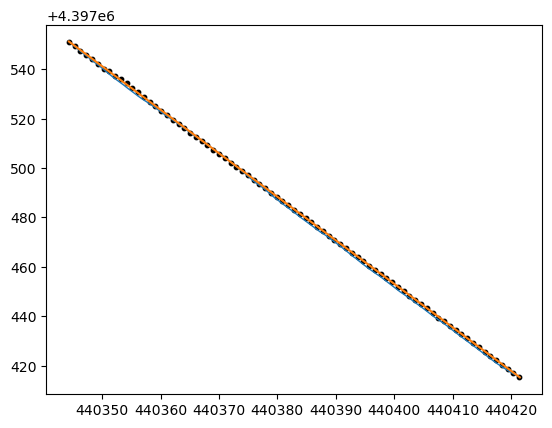

In [16]:
# 检测
simul_line = LineString(simul_points)
_, ax = plt.subplots()
# ax.set_aspect('equal')
# ax.plot(*simul_line.xy)
for point in simul_points:
    ax.scatter(*point.xy, color='black', s=10)
ax.plot(*sample_real_land.xy, linewidth=1)
ax.plot(*sample_straight_land.xy)

simulation begin
[440345.93409065274, 4397532.697626984, 20572, 98.36588, 7.1756024, 4.249954]
-0.002167436960812267
-0.3597667859115238
[440346.9271131323, 4397530.961566399, 20554, 106.4293, 5.7141376, -2.999115]
-0.0034430360694607852
-0.2774526622849194
[440347.92013561184, 4397529.225505814, 20544, 105.395546, 4.094768, -2.500534]
-0.0022407595764062584
-0.20012175632648396
[440348.9131580914, 4397527.489445228, 20530, 105.61099, 2.0649343, 0.99983215]
-0.0012020402327498436
-0.10061070436624178
[440349.90618057095, 4397525.753384643, 20512, 113.96249, 7.3333926, 1.7494202]
-0.007032312317355559
-0.3376918374151565
[440350.89920305053, 4397524.017324058, 20503, 104.23728, 6.2158747, -6.7497253]
-0.0025656487436891183
-0.3077218348055841
[440351.89222553006, 4397522.281263473, 20485, 126.34746, 6.9853773, 2.9994965]
-0.009138582427012602
-0.2843833301258479
[440352.88524800964, 4397520.545202889, 20481, 127.11686, 11.60355, 5.499649]
-0.015204456637887052
-0.4680168258174192
[44035

/var/folders/r2/bv03lgdn7y58thlc1ntrzgvc0000gn/T/ipykernel_54994/2170814722.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(np.cos(aspect) * (lambdas[0] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight)
/var/folders/r2/bv03lgdn7y58thlc1ntrzgvc0000gn/T/ipykernel_54994/2170814722.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(np.sin(aspect) * (lambdas[2] * slope + lambdas[1] * np.abs(curvature)) * vehicle_wheel_width / vehicle_weight)
/var/folders/r2/bv03lgdn7y58thlc1ntrzgvc0000gn/T/ipykernel_54994/2170814722.py:67: FutureWarning: Series.__getitem__ treating keys a

[440359.1692369748, 4397552.217310663, 20420, 78.11134, 9.534728, 2.2506714]
0.004641817233055392
-0.47014606793605707
[440360.1710901071, 4397550.486331085, 20400, 66.99484, 6.420358, -11.0004425]
0.0029423361449136603
-0.3048257419655019
[440361.17294323945, 4397548.755351506, 20413, 58.799484, 17.367067, 26.499939]
0.011909260388747511
-0.7639836856772946
[440362.1747963718, 4397547.024371928, 20409, 62.10273, 7.4069123, 27.250671]
-0.001425939812475382
-0.34802078574078826
[440363.17664950405, 4397545.29339235, 20398, 88.5312, 10.024988, 27.249146]
9.326508137428648e-05
-0.5250353363486951
[440364.1785026364, 4397543.562412771, 20387, 81.63412, 10.351198, -13.249588]
0.002291985145825507
-0.5246589253676291
[440365.1803557687, 4397541.831433193, 20393, 26.22868, 12.692496, 5.4992676]
0.025096394904230223
-0.28355297535299245
[440366.18220890104, 4397540.100453614, 20402, 24.507404, 13.048479, -1.7505646]
0.02903229777397534
-0.27229725915016134
[440367.18406203337, 4397538.36947403

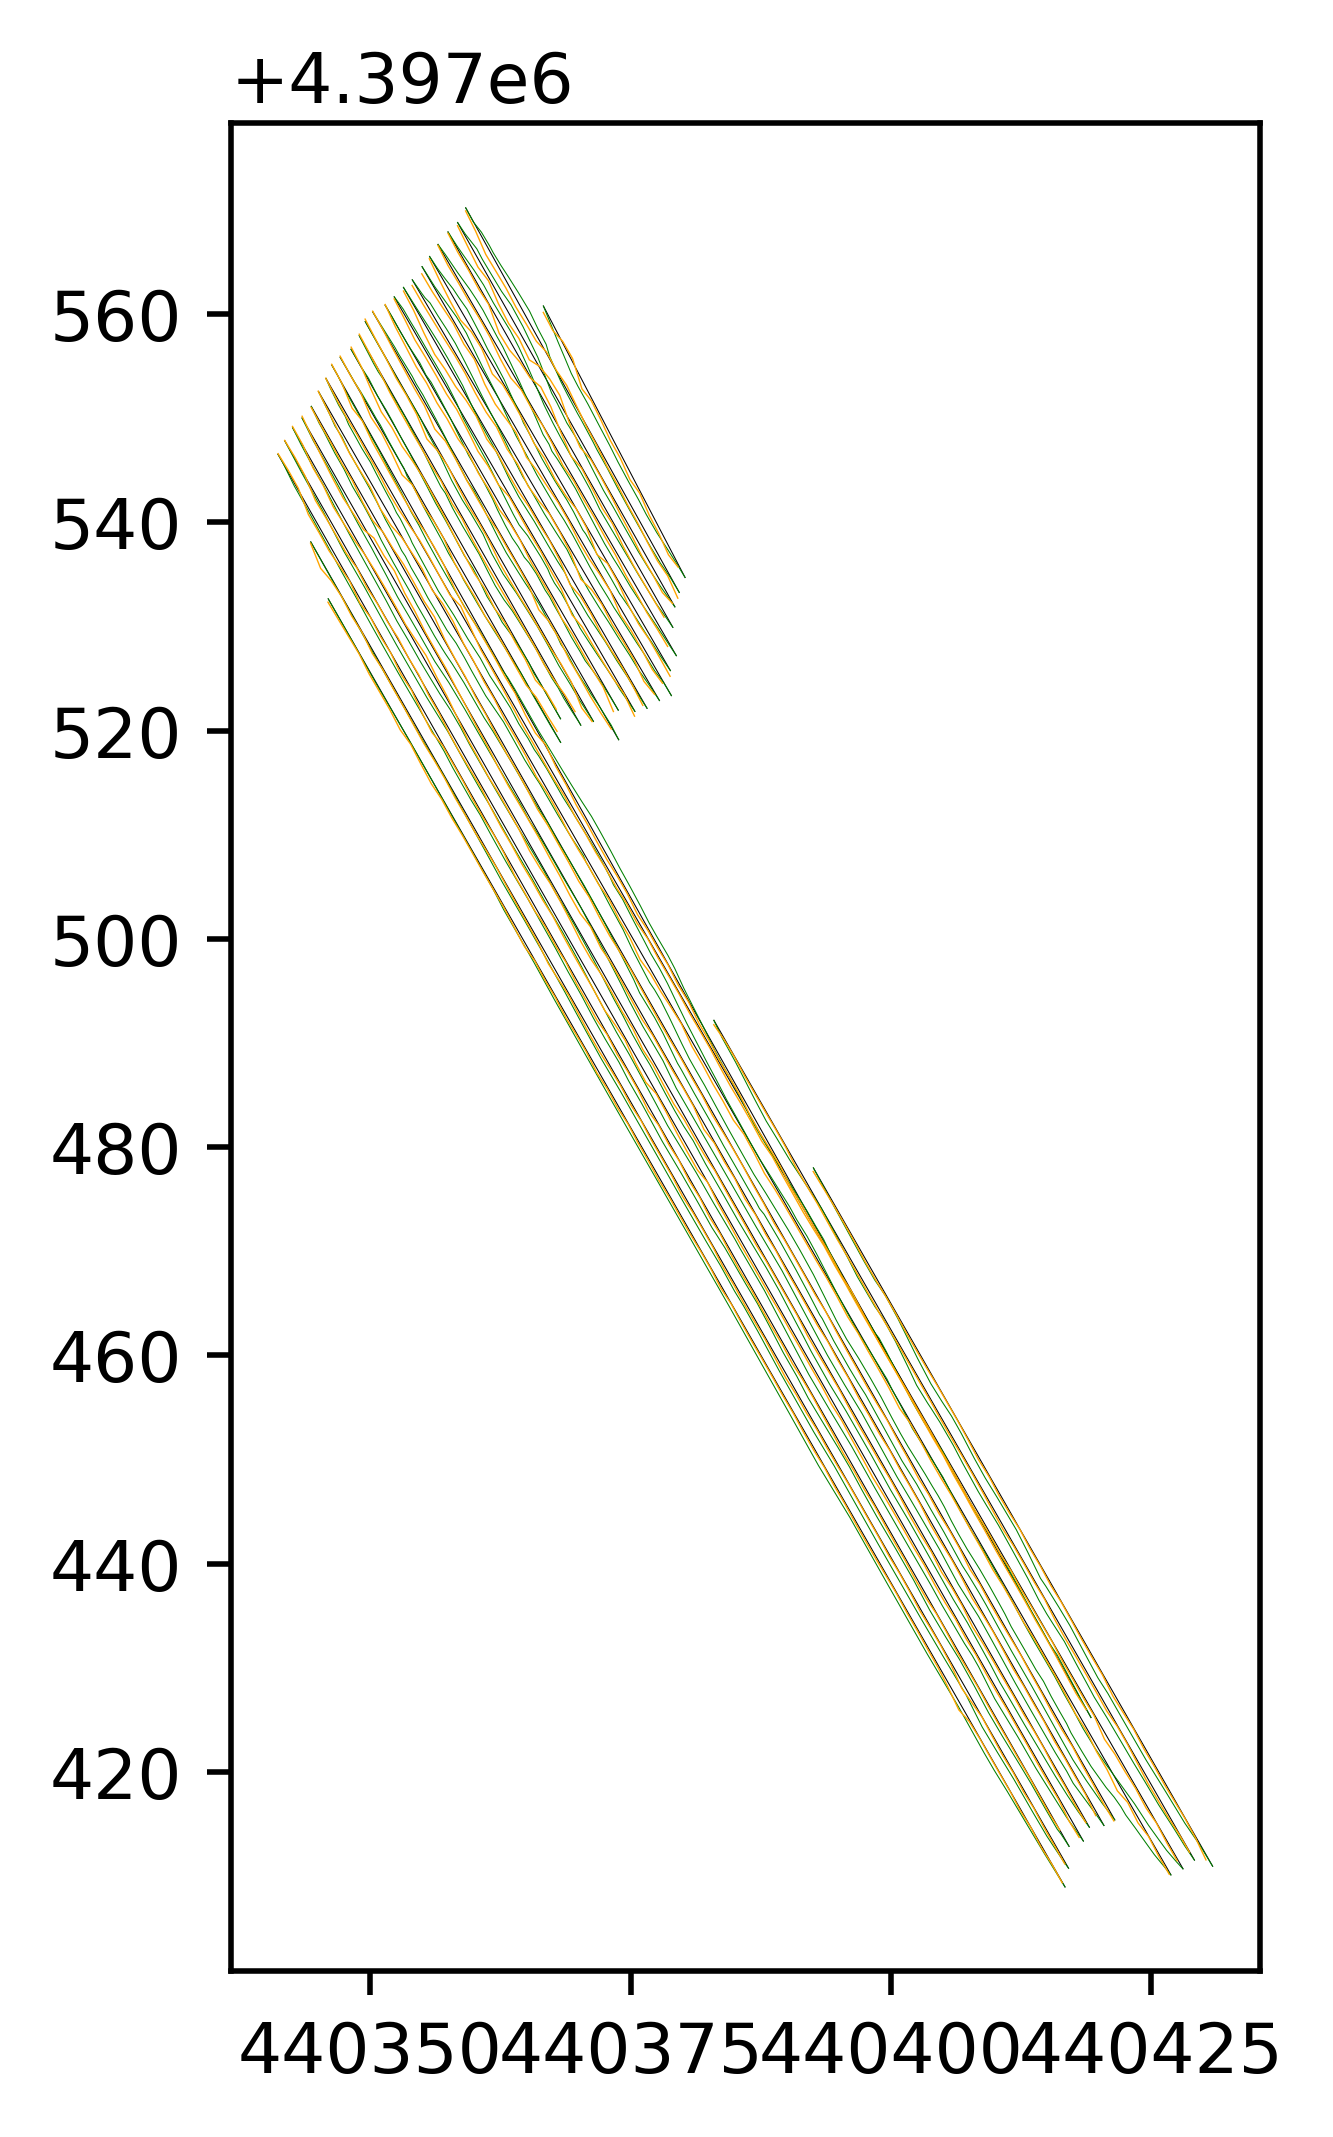

In [24]:
algor_gen_shp_path = r'../gen_paths/gen_02/gen_01.shp'
algor_gen_shp = gpd.read_file(algor_gen_shp_path)
# straight_swath = algor_gen_shp
# 查看所有的路径
_, ax = plt.subplots(dpi=500)
ax.set_aspect('equal')
sample_accuracy = 2
straight_swath.plot(ax=ax, color='black', linewidth=0.15)
real_swath.plot(ax=ax, color='g', linewidth=0.15)
# ax.plot(*all_land.geometry.iloc[useful_land_indexes[land_ind]].exterior.xy, color='y', linewidth=0.5)
# 制作一个数据表，分别是当前的模拟点，以及模拟点到最近真是路径的距离值
distance_points = []

all_distance_data = []
all_simulated_lines = []

print('simulation begin')
for temp_real_line, temp_straight_line in zip(real_swath.geometry, straight_swath.geometry):
    # samples = np.arange(0, temp_real_line.length, sample_accuracy)
    samples = np.arange(0, temp_straight_line.length, sample_accuracy)
    temp_result_points = []
    temp_distance_data = []
    for i, sample in enumerate(samples):
        # TODO: 找到问题所在
        temp_sample_point = temp_straight_line.interpolate(sample)
        temp_point_data = [
            temp_sample_point.x, temp_sample_point.y,
            get_11_from_raster(temp_sample_point, raster.DEM),
            get_11_from_raster(temp_sample_point, raster.ASPECT),
            get_11_from_raster(temp_sample_point, raster.SLOPE),
            # abs(get_11_from_raster(temp_sample_point, raster.SLOPE) - single_slope_mean),
            # abs(get_11_from_raster(temp_sample_point, raster.SLOPE) - single_slope_median),
            get_11_from_raster(temp_sample_point, raster.CURVATURE)
        ]
        # temp_simu_point = model_fit(optimal_params[1:], temp_point_data)
        # temp_simu_point = model_fit_2(optimal_params[1:], temp_point_data)
        # temp_simu_point = model_fit_3(optimal_params[1:], temp_point_data)
        # temp_simu_point = model_fit_4(optimal_params[1:], temp_point_data)
        temp_simu_point = model_fit_5(optimal_params[1:], temp_point_data)
        temp_result_points.append(temp_simu_point)
        # 计算距离
        temp_distance_data.append(temp_simu_point.distance(temp_real_line))
        # 添加路径点的数据
        distance_points.append({'GIS_info': temp_point_data, "simu_point": temp_simu_point, "real_dis": temp_simu_point.distance(temp_real_line)})
    all_distance_data.append(temp_distance_data)
    # print(len(temp_result_points))
    temp_modi_line = LineString(temp_result_points)
    all_simulated_lines.append(temp_modi_line)
    ax.plot(*temp_modi_line.xy, color='orange', linewidth=0.2)
# straight_swath.plot(ax=ax, color='black', linewidth=0.15, linestyle='--')
# plt.legend(['real swath', 'straight swath', 'land boundary', 'simulation'])
# plt.legend(['real swath', 'land boundary', 'simulation'], fontsize=5)
# print('saving')
# plt.savefig('swath_simu.png', dpi=1000)
all_simulated_lines = gpd.GeoDataFrame(geometry=all_simulated_lines)

Text(0.5, 1.0, 'Average difference distance (m)')

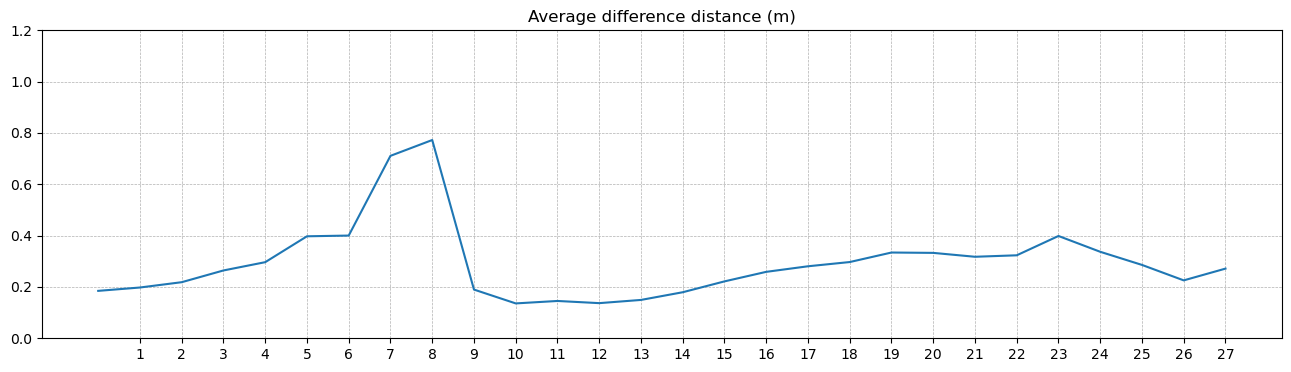

In [19]:
_, ax = plt.subplots(figsize=(16, 4))
all_average_distance = []
for line in all_distance_data:
    all_average_distance.append(np.mean(line))
ax.plot(all_average_distance)
ax.grid(linestyle='--', linewidth=0.5)
plt.xticks(np.arange(1, len(real_swath), 1))
plt.ylim((0, 1.2))
plt.title("Average difference distance (m)")

0.32936878803803193


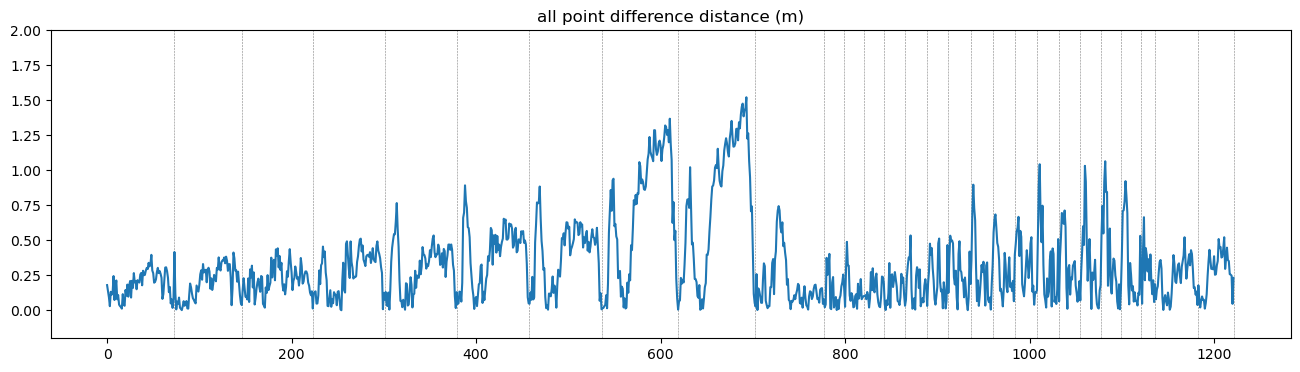

In [20]:
flatten_distances = []
flatten_gap = []
# 控制 plt 的长宽比为 4: 1
plt.figure(figsize=(16, 4))
for i in all_distance_data:
    flatten_distances += i
    flatten_gap.append(len(i))
flatten_distances = np.array(flatten_distances)
# flatten_distances[flatten_distances >= 1] = 0
print(np.mean(flatten_distances))
plt.vlines(np.cumsum(flatten_gap), ymin=-0.2, ymax=2.5, colors="gray", linestyles="dashed", linewidth=0.4)
plt.ylim((-0.2, 2))
plt.plot(flatten_distances)
# 在固定的 x 位置上显示竖直的虚线
plt.title("all point difference distance (m)")
# saving
import csv
with open('opti_group.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(all_distance_data)

#### 不同参数添加结果
* 0.26 使用 添加 curvature
* 0.20 仅 height aspect slope 

In [19]:
df_flatten_distances = pd.DataFrame(flatten_distances)
df_flatten_distances.describe()

,0
count,1222.000000
mean,0.329369
std,0.295335
min,0.000349
25%,0.115778
50%,0.251302
75%,0.443860
max,1.521480


## 通过 “面积比较” 来衡量 real_swath & simul_swath 的区别

In [ ]:
# _, ax = plt.subplots(dpi=300)
# single_simu_swath = all_simulated_lines.geometry.iloc[0]
# single_real_swath = real_swath.geometry.iloc[0]
# ax.plot(*single_simu_swath.xy, linewidth=0.5)
# ax.plot(*single_real_swath.xy, linewidth=0.5)
# ax.set_aspect('equal')
# print(single_simu_swath.hausdorff_distance(single_real_swath))
# print(list(single_simu_swath.coords)[:5])
# print('------------------------------')
# print(list(single_real_swath.coords)[:5])

## 计算各 swath 对应之间的 Hausdorff distance

# 测试算法生成的路径

In [ ]:
algor_gen_shp_path = r'../gen_paths/gen_02/gen_01.shp'
algor_gen_shp = gpd.read_file(algor_gen_shp_path)
# _,ax = plt.subplots(dpi=300)
# ax.plot(*all_land.geometry.iloc[useful_land_indexes[land_ind]].exterior.xy, color='y', linewidth=0.5)
# algor_gen_shp.plot(ax=ax, linewidth=0.2)

## 直线验证距离

In [ ]:
all_distance_data = []
for temp_real_line, temp_straight_line in zip(real_swath.geometry, straight_swath.geometry):
    # samples = np.arange(0, temp_real_line.length, sample_accuracy)
    samples = np.arange(0, temp_straight_line.length, sample_accuracy)
    temp_distance_data = []
    for i, sample in enumerate(samples):
        # TODO: 找到问题所在
        temp_sample_point = temp_straight_line.interpolate(sample)
        temp_distance_data.append(temp_sample_point.distance(temp_real_line))
    all_distance_data.append(temp_distance_data)
# saving
import csv
with open('straight_group.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(all_distance_data)

0.32936878803803193

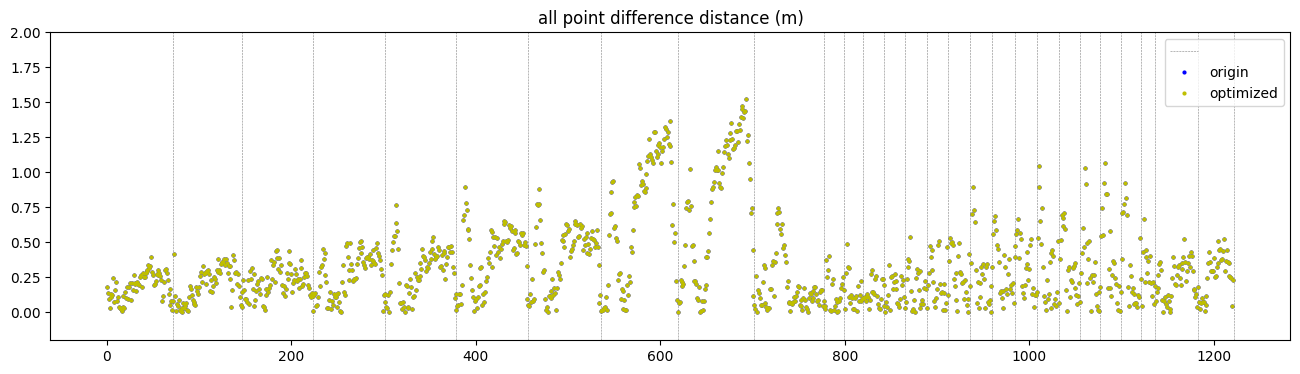

In [24]:
all_distance_combine = []
for temp in all_distance_data:
    all_distance_combine += temp
plt.figure(figsize=(16, 4))
plt.vlines(np.cumsum(flatten_gap), ymin=-0.2, ymax=2.5, colors="gray", linestyles="dashed", linewidth=0.4)
plt.ylim((-0.2, 2))
plt.plot(all_distance_combine, c='b', marker='o', markersize=2, linestyle=' ')
plt.plot(flatten_distances, c='y', marker='o', markersize=2, linestyle=' ')
# plt.plot(all_distance_combine, c='b')
# plt.plot(flatten_distances, c='y')
# 在固定的 x 位置上显示竖直的虚线
plt.title("all point difference distance (m)")
plt.legend(['', 'origin', 'optimized'])
np.mean(all_distance_combine)


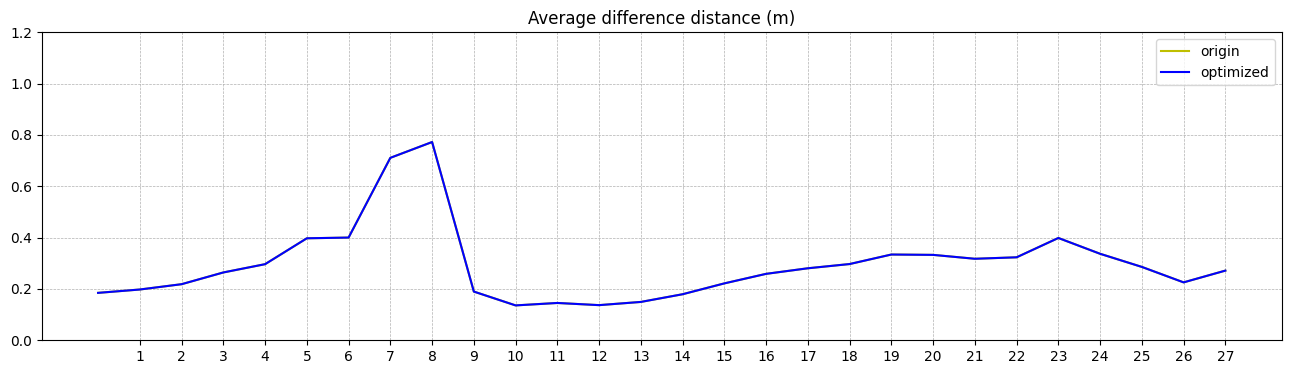

In [23]:
all_distance_mean = []
for temp in all_distance_data:
    all_distance_mean.append(np.mean(temp))
_, ax = plt.subplots(figsize=(16, 4))
# ax.plot(all_distance_mean, 'y', marker='o', markersize=3, linestyle=' ')
# ax.plot(all_average_distance, 'b', marker='o', markersize=3, linestyle=' ')
ax.plot(all_distance_mean, 'y')
ax.plot(all_average_distance, 'b')
ax.grid(linestyle='--', linewidth=0.5)
plt.xticks(np.arange(1, len(real_swath), 1))
plt.ylim((0, 1.2))
plt.title("Average difference distance (m)")
plt.legend(['origin', 'optimized'])

In [21]:
distance_points

[{'GIS_info': [440345.93409065274,
   4397532.697626984,
   20572,
   98.36588,
   7.1756024,
   4.249954],
  'simu_point': <POINT (440345.932 4397532.338)>,
  'real_dis': 0.17983306770758972},
 {'GIS_info': [440346.9271131323,
   4397530.961566399,
   20554,
   106.4293,
   5.7141376,
   -2.999115],
  'simu_point': <POINT (440346.924 4397530.684)>,
  'real_dis': 0.13588181808693756},
 {'GIS_info': [440347.92013561184,
   4397529.225505814,
   20544,
   105.395546,
   4.094768,
   -2.500534],
  'simu_point': <POINT (440347.918 4397529.025)>,
  'real_dis': 0.09224184907235772},
 {'GIS_info': [440348.9131580914,
   4397527.489445228,
   20530,
   105.61099,
   2.0649343,
   0.99983215],
  'simu_point': <POINT (440348.912 4397527.389)>,
  'real_dis': 0.029337648709649167},
 {'GIS_info': [440349.90618057095,
   4397525.753384643,
   20512,
   113.96249,
   7.3333926,
   1.7494202],
  'simu_point': <POINT (440349.899 4397525.416)>,
  'real_dis': 0.13227178192052583},
 {'GIS_info': [440350.8

In [1]:
# import pickle
# with open(r'GIS_data/simul_points_info.pkl', 'wb') as f:
#     pickle.dump(distance_points, f)

NameError: name 'distance_points' is not defined